# **Sistema de Detecção de Fraudes em Medidores de Energia Elétrica**
##### Pesquisadora: Dra. Cynthia Moreira Maia
##### Objetivo: Desenvolver um protótipo de modelo preditivo capaz de identificar perfis anômalos de consumo de energia elétrica, a partir da análise de um dataset composto pelo histórico de consumo mensal de 12 meses de 10.000 unidades consumidoras anonimizadas.
##### Para este experimento, os algoritmos foram implementados utilizando a linguagem Python, no ambiente Colab. Os principais pacotes empregados foram o matplotlib, pandas e scikit-learn.

#### **Instalação e carregamento de bibliotecas**

In [ ]:
pip install -U imbalanced-learn #biblioteca para balanceamento de dados

In [29]:
# Bibliotecas de manipulação e visualização de dados
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from collections import Counter
import time

# Bibliotecas de pre-processamento dos dados
from sklearn.preprocessing import OneHotEncoder
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import MinMaxScaler

# Classes do modelo de aprendizado
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import plot_tree

# Funções de avaliação e validação dos modelos
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix

import warnings
warnings.filterwarnings('ignore')

### **Análise Exploratória dos Dados - Exploratory Data Analysis (EDA)**

Como primeira etapa do estudo, realizamos uma análise com os seguintes objetivos:

1. **Conhecer a estrutura dos dados**: Verificar os tipos dos atributos
2. **Verificar qualidade dos dados**: Identificar valores faltosos (missing values)
3. **Analisar relações entre variáveis**: Investigar correlações entre os atributos e com a variável alvo (fraude)

**Principais descobertas:**
- **Estrutura dos atributos**:
  - Há um atributo categórico representando a categoria (Residencial, Comercial, Industrial). Como existe um atributo categórico, teremos que transformar para numérico, visto que alguns algoritmos de aprendizado de máquina só trabalham com dados numéricos.
  - Todos os demais atributos são numéricos (mes_1, mes_2,..., mes_12)
- **Qualidade dos dados**:
  - Não há valores faltosos em nenhuma das colunas. Isso é importante porque alguns algoritmos não funcionam adequadamente na presença de dados ausentes, e também é importante para garantir qualidade nos dados. Caso houvesse valores ausentes, seria necessário definir a melhor estratégia de tratamento, como: imputação por medidas de tendência central (média, mediana, moda); métodos mais sofisticados como KNN Imputer.
- **Relações entre variáveis**:
  - As análises de correlação forneceram insights, que existe alta correlação entre os meses o que indica forte redundância de atributos.
  - A variável de fraude apresenta correlação fraca e negativa com os valores absolutos de consumo, sugerindo que a identificação de fraudes não depende diretamente do nível de consumo. Observa-se, ainda, que nenhuma variável individual apresenta correlação forte com a classe de fraude.
  - Esses resultados reforçam a necessidade de engenharia de atributos para a construção de variáveis mais informativas, capazes de capturar padrões anômalos de comportamento. Ao gerar novos atributos, indícios como consumo no último mês significativamente abaixo da média histórica e padrões de redução progressiva ao longo do tempo são considerados comportamentos suspeitos e potencialmente associados a fraudes.
  - **Evidências quantitativas**:
- `taxa_crescimento`: correlação de -0.911 com fraude (forte indicador negativo)
- `desvio_padrao_mensal`: correlação de 0.114 (fraco indicador positivo)

In [30]:
#carregamento dos dados
df = pd.read_csv("/content/drive/MyDrive/Desafio- Energia eletrica/dataset_desafio_energia.csv")
df.drop("id_cliente", axis=1, inplace=True) #Remove a variável identificadora, pois não agrega informação preditiva para a identificação de perfis anômalos.
df

,categoria,mes_1,mes_2,mes_3,mes_4,mes_5,mes_6,mes_7,mes_8,mes_9,mes_10,mes_11,mes_12,fraude
0,Residencial,196,184,207,179,164,134,163,168,157,164,180,202,0
1,Residencial,267,273,237,223,203,196,209,196,221,237,232,285,0
2,Residencial,216,233,213,181,176,151,180,167,192,188,216,237,0
3,Industrial,7289,7203,6833,5870,5619,4491,4596,4710,5278,5629,6044,7363,0
4,Residencial,222,183,210,184,147,133,157,163,173,184,175,203,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,Residencial,305,275,276,262,247,212,237,254,238,258,317,323,0
9996,Residencial,297,271,281,230,209,221,217,223,218,262,247,304,0
9997,Residencial,306,252,289,236,233,198,214,221,228,266,282,269,0
9998,Residencial,244,212,202,178,163,166,144,159,170,176,192,244,0


In [32]:
target_col = "fraude"
print("Quantas classes existem nesse dataset?\n%d" %(len(df[target_col].unique())))
print("Quantos valores existem na coluna categoria e quais são?\n%d" %(len(df["categoria"].unique())), df["categoria"].value_counts())
print("\nQuantas instâncias existem no dataset?\n%d" % df.shape[0])
print("\nQuantos atributos existem no dataset?\n%d" % (df.shape[1]-1))
print("\nQue atributos são esses?\n%s" % (str([k for k in df.keys() if k != target_col])))
print("\nQual o numero de instâncias por classe?") #verificar desbalanceamento entre classes
print(df[target_col].value_counts())

Quantas classes existem nesse dataset?
2
Quantos valores existem na coluna categoria e quais são?
3 categoria
Residencial    8028
Comercial      1471
Industrial      501
Name: count, dtype: int64

Quantas instâncias existem no dataset?
10000

Quantos atributos existem no dataset?
13

Que atributos são esses?
['categoria', 'mes_1', 'mes_2', 'mes_3', 'mes_4', 'mes_5', 'mes_6', 'mes_7', 'mes_8', 'mes_9', 'mes_10', 'mes_11', 'mes_12']

Qual o numero de instâncias por classe?
fraude
0    9474
1     526
Name: count, dtype: int64


In [33]:
#verificar se tem dados faltosos
print("Valores Faltosos:", df.isnull().sum())

Valores Faltosos: categoria    0
mes_1        0
mes_2        0
mes_3        0
mes_4        0
mes_5        0
mes_6        0
mes_7        0
mes_8        0
mes_9        0
mes_10       0
mes_11       0
mes_12       0
fraude       0
dtype: int64


In [34]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   categoria  10000 non-null  object
 1   mes_1      10000 non-null  int64 
 2   mes_2      10000 non-null  int64 
 3   mes_3      10000 non-null  int64 
 4   mes_4      10000 non-null  int64 
 5   mes_5      10000 non-null  int64 
 6   mes_6      10000 non-null  int64 
 7   mes_7      10000 non-null  int64 
 8   mes_8      10000 non-null  int64 
 9   mes_9      10000 non-null  int64 
 10  mes_10     10000 non-null  int64 
 11  mes_11     10000 non-null  int64 
 12  mes_12     10000 non-null  int64 
 13  fraude     10000 non-null  int64 
dtypes: int64(13), object(1)
memory usage: 1.1+ MB


##### **Como o consumo mensal se distribui ao longo do ano de clientes com fraudes confirmadas  e sem fraudes confirmadas?**
Isso pode revelar insights dos padroes de forma visual de um cliente fraudador e um cliente honesto.
A análise comparativa (grafico de linhas a seguir) revela padrões distintos no consumo mensal entre os grupos. A linha azul, representando clientes sem fraudes confirmadas, apresenta estabilidade consistente ao longo do ano, com pequenas variações sazonais. Em contraste, a linha laranja, correspondente a clientes com fraudes confirmadas, exibe um padrão de queda progressiva: consumo elevado no início do ano seguido de reduções mensais consistentes, resultando em valores significativamente mais baixos no último trimestre. Este comportamento decrescente  pode servir como alerta preventivo, sugerindo que monitorar trajetórias de consumo com declínios sustentados pode auxiliar na identificação preventiva de atividades suspeitas.


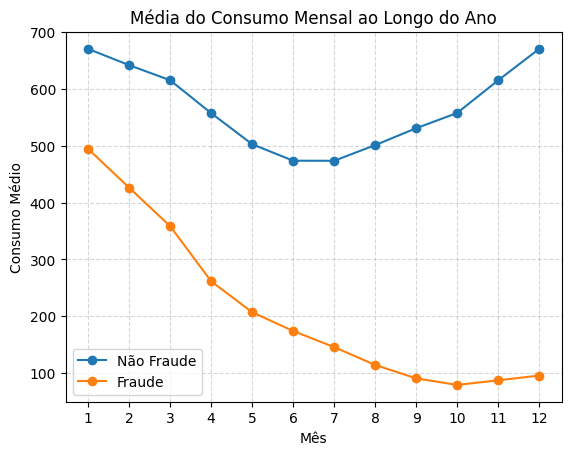

In [35]:
#Análise do Consumo Médio Mensal

# Separação das classes
df_fraude = df[df['fraude'] == 1]
df_nao_fraude = df[df['fraude'] == 0]

# Colunas dos meses
colunas_meses = [f'mes_{i}' for i in range(1, 13)]

# Cálculo das médias mensais
media_fraude = df_fraude[colunas_meses].mean()
media_nao_fraude = df_nao_fraude[colunas_meses].mean()

# Visualização
plt.plot(
    range(1, 13),
    media_nao_fraude.values,
    marker='o',
    label='Não Fraude'
)

plt.plot(
    range(1, 13),
    media_fraude.values,
    marker='o',
    label='Fraude'
)


plt.title('Média do Consumo Mensal ao Longo do Ano')
plt.xlabel('Mês')
plt.ylabel('Consumo Médio')
plt.xticks(range(1, 13))
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend()
plt.savefig("grafico_linhas.png")
plt.show()


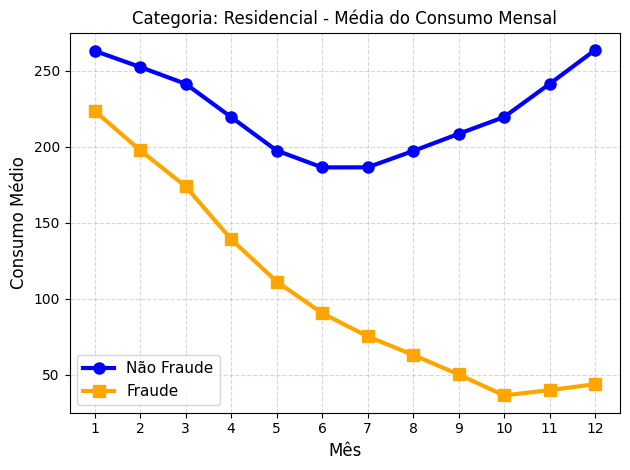

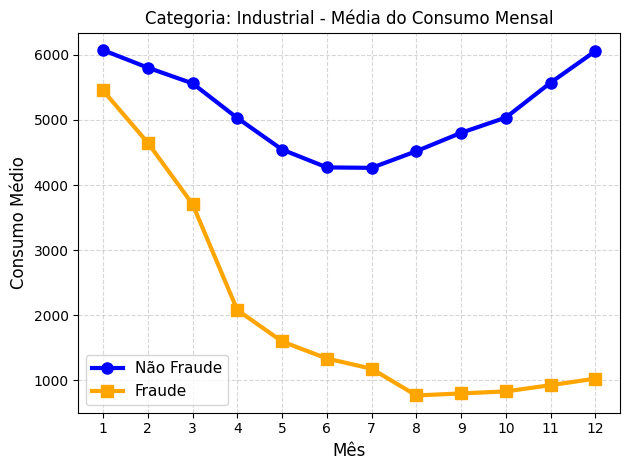

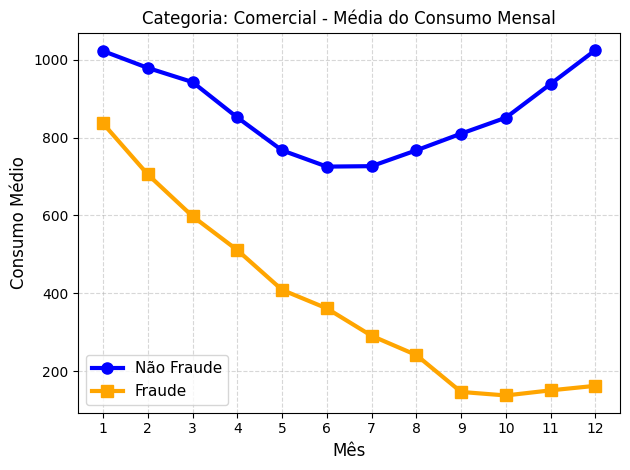

In [36]:
# Análise do consumo mensal por categoria

if 'categoria' in df.columns:
    categorias = df['categoria'].unique()

    for categoria in categorias:
        df_categoria = df[df['categoria'] == categoria]
        df_fraude_cat = df_categoria[df_categoria['fraude'] == 1]
        df_nao_fraude_cat = df_categoria[df_categoria['fraude'] == 0]

        media_fraude_cat = df_fraude_cat[colunas_meses].mean()
        media_nao_fraude_cat = df_nao_fraude_cat[colunas_meses].mean()

        #Visualização
        plt.plot(range(1, 13), media_nao_fraude_cat.values,
                    marker='o', label='Não Fraude', color='blue', linewidth=3, markersize=8)
        plt.plot(range(1, 13), media_fraude_cat.values,
                    marker='s', label='Fraude', color='orange', linewidth=3, markersize=8)


        plt.title(f'Categoria: {categoria} - Média do Consumo Mensal')
        plt.xlabel('Mês', fontsize=12)
        plt.ylabel('Consumo Médio', fontsize=12)
        plt.xticks(range(1, 13))
        plt.grid(True, linestyle='--', alpha=0.5)
        plt.legend(fontsize=11)

        plt.tight_layout()
        plt.savefig(f"grafico_categoria_{categoria}.png")
        plt.show()

### **Análise de Correlação entre Atributos Extraídos**
 - Verificar se existe alguma correlação entre os atributos extraídas, se há informacao redundante entre elas.

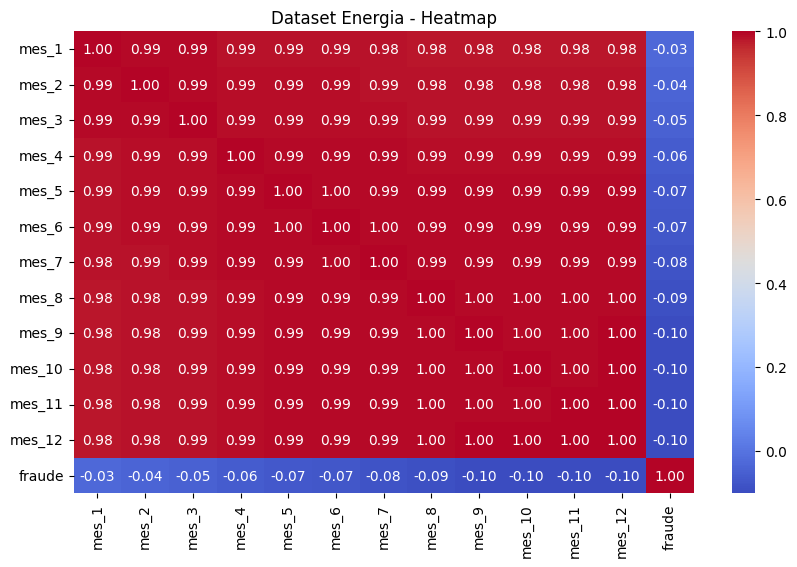

In [37]:
# Selecionar apenas colunas numéricas
numeric_df = df.select_dtypes(include=['int64', 'float64'])

# Matriz de correlação
correlation_matrix = numeric_df.corr()

# Visualização

plt.figure(figsize=(10,6))
sns.heatmap(
    numeric_df.corr(),
    annot=True,
    cmap="coolwarm",
    fmt=".2f"
)

plt.title("Dataset Energia - Heatmap")
plt.savefig("fig_heatmap.png")
plt.show()


##### Diante da análise com heatmap, que forneceu fortes correlações entre os atributos, indicando forte redundância e baixa diversidade informativa para o modelo, propõe-se a criação de novos atributos que capturem anomalias temporais.

In [38]:
#Sugestao de novos atributos

# Crescimento absoluto anual
df['crescimento_anual'] = df['mes_12'] - df['mes_1']
# Taxa de crescimento anual (percentual)
df['taxa_crescimento'] = (df['mes_12'] - df['mes_1']) / df['mes_1'].clip(lower=0.01)
# Média móvel dos últimos 3 meses
df['media_movel_3m'] = df[['mes_9','mes_10', 'mes_11']].mean(axis=1)
# Variabilidade do consumo ao longo do ano
df['desvio_padrao_mensal'] = df[[f'mes_{i}' for i in range(1, 13)]].std(axis=1)
# Comparação do último mês com média recente
df['mes_atual_vs_media_passada'] = df['mes_12'] / df[['mes_9', 'mes_10', 'mes_11']].mean(axis=1)

"""df['pct_ultimo_mes_vs_media'] = df['mes_12'] / df[[f'mes_{i}' for i in range(1, 12)]].mean(axis=1)
df['ultimo_vs_max'] = df['mes_12'] / df[[f'mes_{i}' for i in range(1, 13)]].max(axis=1)"""

"df['pct_ultimo_mes_vs_media'] = df['mes_12'] / df[[f'mes_{i}' for i in range(1, 12)]].mean(axis=1)\ndf['ultimo_vs_max'] = df['mes_12'] / df[[f'mes_{i}' for i in range(1, 13)]].max(axis=1)"

In [39]:
#Análise de correlação após a criação dos novos atributos

novos_atributos = ['crescimento_anual', 'taxa_crescimento', 'media_movel_3m', 'desvio_padrao_mensal',
                  'mes_atual_vs_media_passada']
# Matriz de correlação com a variável alvo
df_model = df[novos_atributos + ['fraude']]
correlation_matrix = df_model.corr()
correlation_matrix

,crescimento_anual,taxa_crescimento,media_movel_3m,desvio_padrao_mensal,mes_atual_vs_media_passada,fraude
crescimento_anual,1.000000,0.427322,0.000735,-0.426192,0.136341,-0.368760
taxa_crescimento,0.427322,1.000000,0.087365,-0.109195,0.345799,-0.911084
media_movel_3m,0.000735,0.087365,1.000000,0.864619,0.004632,-0.100076
desvio_padrao_mensal,-0.426192,-0.109195,0.864619,1.000000,0.017248,0.114032
mes_atual_vs_media_passada,0.136341,0.345799,0.004632,0.017248,1.000000,-0.148251
fraude,-0.368760,-0.911084,-0.100076,0.114032,-0.148251,1.000000


###### **Interpretação**:

A análise de correlação indica que atributos relacionados à redução do consumo ao longo do ano, como taxa_crescimento (−0.91) e crescimento_anual (−0.36), apresentam associação negativa com a variável fraude, sugerindo que quedas no consumo tendem a ocorrer com maior frequência em casos fraudulentos. Atributos como desvio_padrao_mensal (0.11) indicam uma associação positiva, ainda que fraca, entre maior variabilidade no consumo e a ocorrência de fraude. Ressalta-se que tais resultados representam associações estatísticas, não sendo possível estabelecer relações de causalidade apenas a partir dessa análise.


## **Pré-Processamento e Processamento dos Dados**

As técnicas de pré-processamento visam modificar os dados de entrada para um formato que seja possível realizar análises com um melhor desempenho, que melhorem a qualidade dos dados.

Foram conduzidas duas abordagens distintas:

---

### Abordagem I

Utilizou-se os atributos originais, sem balanceamento de classes e sem normalização.

---

### Abordagem II

Empregaram-se os novos atributos derivados, aplicou-se balanceamento via SMOTE (Synthetic Minority Over-sampling Technique) e normalização via Min-Max para algoritmos sensíveis à escala. Decidiu-se usar o Stratified K-Fold, por preservar a proporção de classes em cada fold.

---

Verificou-se um significativo desbalanceamento entre as classes [9474, 526]. Para mitigar este problema, aplicou-se SMOTE, em que criou instâncias sintéticas das classes minoritárias, que gera novas amostras sintéticas da classe minoritária, em vez de simplesmente duplicar as amostras existentes.  

Para garantir avaliação justa sem vazamento de dados, o SMOTE é aplicado apenas aos dados de treino em cada fold da validação cruzada (10 folds).

---

Outro fator observado, foi que os atributos estavam em escalas diferentes. Dado que os atributos possuíam escalas significativamente diferentes, aplicou-se normalização via Min-Max para algoritmos sensíveis a escala como KNN.  

Algoritmos baseados em árvore (Random Forest), por serem invariantes a escala, foram treinados com os dados originais.

---

Adotou-se o Min-Max, que consiste em colocar os valores numa escala de [0,1].  
Para isso, seu cálculo se baseia na função que divide o valor em questão subtraído do menor valor existente e divide esse  resultado pela subtração do maior menos o menor valores existentes.  

Com isso, a escala passa a ser um valor percentual e decimal menor que um.

---

### Ponto de destaque

Neste estudo foram avaliados apenas dois algoritmos de aprendizado de máquina. Entretanto, reconhece-se que existem diversas outras abordagens que poderiam ser exploradas. A escolha concentrou-se principalmente em modelos baseados em árvores de decisão, em razão de suas vantagens, como a interpretabilidade dos resultados e a possibilidade de visualização dos padrões e regras aprendidas durante o processo de treinamento.  

Outro ponto relevante deste estudo é a adoção de múltiplas métricas de avaliação, incluindo precisão, recall, F1-score e acurácia. Essa escolha se justifica pelo desbalanceamento entre as classes, no qual a acurácia isoladamente pode fornecer uma visão distorcida do desempenho do modelo.

---

Além disso, ressalta-se que não foi realizada a etapa de ajuste fino de hiperparâmetros (hyperparameter tuning). Métodos como Grid Search ou Random Search poderiam ser empregados para identificar configurações mais adequadas dos hiperparâmetros, o que potencialmente resultaria em melhorias no desempenho preditivo dos modelos.  

Assim, tais procedimentos são indicados como trabalhos futuros para o aprimoramento e resultado da solução.


In [40]:
# # One-Hot Encoding da variável categórica 'categoria'
encoder = OneHotEncoder(sparse_output=False, drop='first')
categoria_encoded = encoder.fit_transform(df[['categoria']])
categoria_df = pd.DataFrame(categoria_encoded,
                           columns=encoder.get_feature_names_out(['categoria']))
df = pd.concat([df.drop('categoria', axis=1), categoria_df], axis=1)
df

,mes_1,mes_2,mes_3,mes_4,mes_5,mes_6,mes_7,mes_8,mes_9,mes_10,mes_11,mes_12,fraude,crescimento_anual,taxa_crescimento,media_movel_3m,desvio_padrao_mensal,mes_atual_vs_media_passada,categoria_Industrial,categoria_Residencial
0,196,184,207,179,164,134,163,168,157,164,180,202,0,6,0.030612,167.000000,20.792627,1.209581,0.0,1.0
1,267,273,237,223,203,196,209,196,221,237,232,285,0,18,0.067416,230.000000,30.040755,1.239130,0.0,1.0
2,216,233,213,181,176,151,180,167,192,188,216,237,0,21,0.097222,198.666667,26.910063,1.192953,0.0,1.0
3,7289,7203,6833,5870,5619,4491,4596,4710,5278,5629,6044,7363,0,74,0.010152,5650.333333,1057.415585,1.303109,1.0,0.0
4,222,183,210,184,147,133,157,163,173,184,175,203,0,-19,-0.085586,177.333333,25.880260,1.144737,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,305,275,276,262,247,212,237,254,238,258,317,323,0,18,0.059016,271.000000,33.933089,1.191882,0.0,1.0
9996,297,271,281,230,209,221,217,223,218,262,247,304,0,7,0.023569,242.333333,33.589320,1.254470,0.0,1.0
9997,306,252,289,236,233,198,214,221,228,266,282,269,0,-37,-0.120915,258.666667,33.178580,1.039948,0.0,1.0
9998,244,212,202,178,163,166,144,159,170,176,192,244,0,0,0.000000,179.333333,32.348950,1.360595,0.0,1.0


# Abordagem I

In [41]:
# Meses originais para testar
atributos_originais = [f'mes_{i}' for i in range(1, 13)] + ['categoria_Industrial', 'categoria_Residencial']

X = df[atributos_originais]
y = df['fraude']

Fold 01 | Acc: 1.0000 | Prec: 1.0000 | Recall: 1.0000 | F1: 1.0000| Tempo Treino: 0.0467| Tempo Teste: 0.2002
Matriz de Confusão:
[[1895    0]
 [   0  105]]


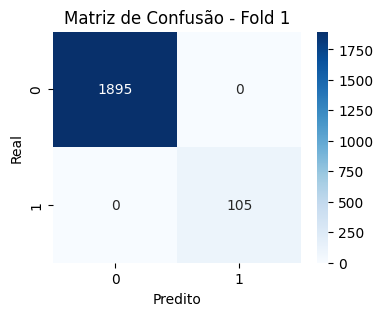

Fold 02 | Acc: 1.0000 | Prec: 1.0000 | Recall: 1.0000 | F1: 1.0000| Tempo Treino: 0.0286| Tempo Teste: 0.1333
Matriz de Confusão:
[[1895    0]
 [   0  105]]


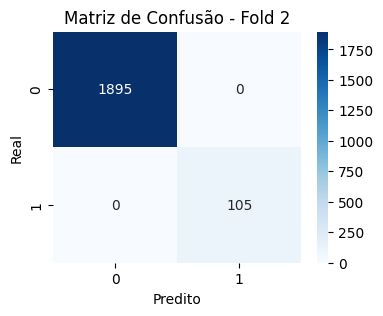

Fold 03 | Acc: 1.0000 | Prec: 1.0000 | Recall: 1.0000 | F1: 1.0000| Tempo Treino: 0.0324| Tempo Teste: 0.1289
Matriz de Confusão:
[[1895    0]
 [   0  105]]


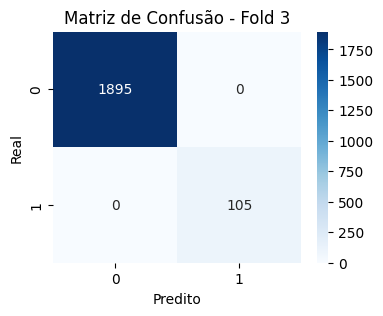

Fold 04 | Acc: 0.9985 | Prec: 1.0000 | Recall: 0.9714 | F1: 0.9855| Tempo Treino: 0.0230| Tempo Teste: 0.1181
Matriz de Confusão:
[[1895    0]
 [   3  102]]


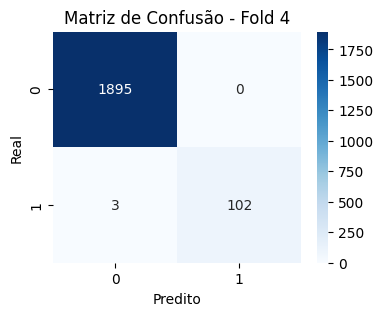

Fold 05 | Acc: 1.0000 | Prec: 1.0000 | Recall: 1.0000 | F1: 1.0000| Tempo Treino: 0.0210| Tempo Teste: 0.1148
Matriz de Confusão:
[[1894    0]
 [   0  106]]


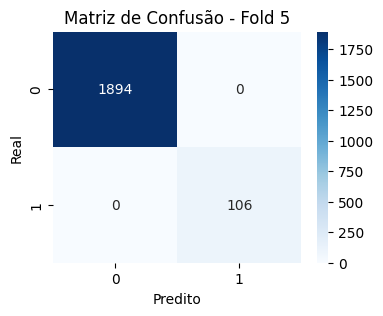

In [42]:
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

tempo_treino = []
tempo_teste = []

acc_list = []
prec_list = []
recall_list = []
f1_list = []

for fold, (train_index, test_index) in enumerate(kf.split(X, y), 1):

    X_train = X.iloc[train_index]
    X_test  = X.iloc[test_index]
    y_train = y.iloc[train_index]
    y_test  = y.iloc[test_index]

    clf = KNeighborsClassifier()

    start_train = time.perf_counter()
    clf.fit(X_train, y_train)
    tempo_treino.append(time.perf_counter() - start_train)


    start_test = time.perf_counter()
    y_pred = clf.predict(X_test)
    tempo_teste.append(time.perf_counter() - start_test)

    acc_list.append(accuracy_score(y_test, y_pred))
    prec_list.append(precision_score(y_test, y_pred))
    recall_list.append(recall_score(y_test, y_pred))
    f1_list.append(f1_score(y_test, y_pred))

    print(f"Fold {fold:02d} | "
          f"Acc: {acc_list[-1]:.4f} | "
          f"Prec: {prec_list[-1]:.4f} | "
          f"Recall: {recall_list[-1]:.4f} | "
          f"F1: {f1_list[-1]:.4f}| "
          f"Tempo Treino: {tempo_treino[-1]:.4f}| "
          f"Tempo Teste: {tempo_teste[-1]:.4f}")

    cm = confusion_matrix(y_test, y_pred)
    print("Matriz de Confusão:")
    print(cm)

    # Visualização
    plt.figure(figsize=(4, 3))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.xlabel("Predito")
    plt.ylabel("Real")
    plt.title(f"Matriz de Confusão - Fold {fold}")
    plt.show()


In [43]:
kf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

tempo_treino = []
tempo_teste = []

acc_list = []
prec_list = []
recall_list = []
f1_list = []

for fold, (train_index, test_index) in enumerate(kf.split(X, y), 1):

    X_train = X.iloc[train_index]
    X_test  = X.iloc[test_index]
    y_train = y.iloc[train_index]
    y_test  = y.iloc[test_index]


    clf = RandomForestClassifier()


    start_train = time.perf_counter()
    clf.fit(X_train, y_train)
    tempo_treino.append(time.perf_counter() - start_train)


    start_test = time.perf_counter()
    y_pred = clf.predict(X_test)
    y_pred_proba = clf.predict_proba(X_test)
    #print(y_pred_proba)
    #Uma predicao interessante para classificacao, enquanto predict() diz apenas 0 ou 1, predict_proba() diz quão confiante o modelo está.
    tempo_teste.append(time.perf_counter() - start_test)

    acc_list.append(accuracy_score(y_test, y_pred))
    prec_list.append(precision_score(y_test, y_pred, zero_division=0))
    recall_list.append(recall_score(y_test, y_pred))
    f1_list.append(f1_score(y_test, y_pred))

    print(f"Fold {fold:02d} | "
          f"Acc: {acc_list[-1]:.4f} | "
          f"Prec: {prec_list[-1]:.4f} | "
          f"Recall: {recall_list[-1]:.4f} | "
          f"F1: {f1_list[-1]:.4f}")


Fold 01 | Acc: 1.0000 | Prec: 1.0000 | Recall: 1.0000 | F1: 1.0000
Fold 02 | Acc: 1.0000 | Prec: 1.0000 | Recall: 1.0000 | F1: 1.0000
Fold 03 | Acc: 1.0000 | Prec: 1.0000 | Recall: 1.0000 | F1: 1.0000
Fold 04 | Acc: 0.9990 | Prec: 0.9811 | Recall: 1.0000 | F1: 0.9905
Fold 05 | Acc: 0.9980 | Prec: 1.0000 | Recall: 0.9623 | F1: 0.9808
Fold 06 | Acc: 1.0000 | Prec: 1.0000 | Recall: 1.0000 | F1: 1.0000
Fold 07 | Acc: 1.0000 | Prec: 1.0000 | Recall: 1.0000 | F1: 1.0000
Fold 08 | Acc: 1.0000 | Prec: 1.0000 | Recall: 1.0000 | F1: 1.0000
Fold 09 | Acc: 1.0000 | Prec: 1.0000 | Recall: 1.0000 | F1: 1.0000
Fold 10 | Acc: 1.0000 | Prec: 1.0000 | Recall: 1.0000 | F1: 1.0000


In [44]:
print("Top atributos mais importantes:")
atributos_importances = clf.feature_importances_
atributos_df = pd.DataFrame({
    'Atributos': X.columns,
    'Importancia': atributos_importances
}).sort_values('Importancia', ascending=False)
print(atributos_df.head(20))

Top atributos mais importantes:
                Atributos  Importancia
9                  mes_10     0.237320
11                 mes_12     0.178403
10                 mes_11     0.163121
8                   mes_9     0.136906
7                   mes_8     0.099265
5                   mes_6     0.062331
6                   mes_7     0.037923
4                   mes_5     0.019903
2                   mes_3     0.016413
0                   mes_1     0.015166
3                   mes_4     0.011561
1                   mes_2     0.010381
13  categoria_Residencial     0.008805
12   categoria_Industrial     0.002502


**Interpretação da Importância dos Atributos**

A categoria do consumidor, de forma isolada, apresenta baixo poder preditivo quando comparada às variáveis relacionadas ao comportamento do consumo ao longo do tempo. A análise de importância das variáveis indica que os meses mais recentes do histórico de consumo, especialmente do 9º ao 12º mês, concentram a maior parte do poder discriminativo do modelo. Esse resultado sugere que variações recentes, como quedas ou alterações abruptas no consumo, são mais relevantes para a detecção de fraudes do que informações históricas mais antigas. A substituição das variáveis mensais brutas por atributos derivados permite reduzir a redundância e a dimensionalidade do problema. Assim, decidiu-se investigar melhor com novos atributos criados.

# Abordagem II

In [45]:

atributos_modelo = ['crescimento_anual', 'taxa_crescimento', 'media_movel_3m', 'desvio_padrao_mensal',
                  'mes_atual_vs_media_passada']

X = df[atributos_modelo]
y = df['fraude']

In [46]:
# Contagem de instâncias por classe:
Counter(df['fraude'])

Counter({0: 9474, 1: 526})

Counter({0: 8526, 1: 8526})
Fold 01 | Acc: 1.0000 | Prec: 1.0000 | Recall: 1.0000 | F1: 1.0000| Tempo Treino: 0.0546| Tempo Teste: 0.0453
Matriz de Confusão:
[[948   0]
 [  0  52]]


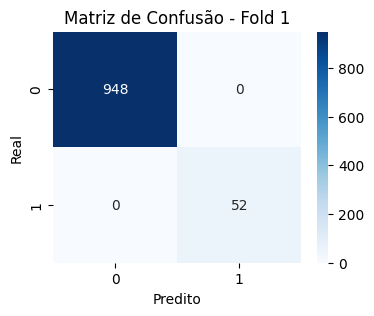

Counter({0: 8526, 1: 8526})
Fold 02 | Acc: 1.0000 | Prec: 1.0000 | Recall: 1.0000 | F1: 1.0000| Tempo Treino: 0.0780| Tempo Teste: 0.0441
Matriz de Confusão:
[[948   0]
 [  0  52]]


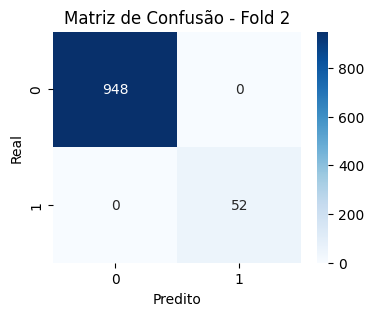

Counter({0: 8526, 1: 8526})
Fold 03 | Acc: 1.0000 | Prec: 1.0000 | Recall: 1.0000 | F1: 1.0000| Tempo Treino: 0.0446| Tempo Teste: 0.0298
Matriz de Confusão:
[[948   0]
 [  0  52]]


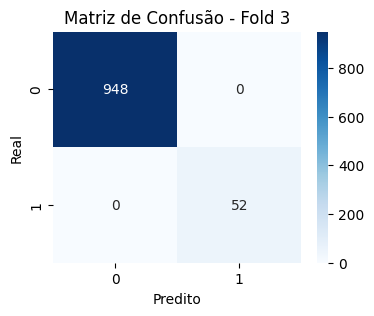

Counter({0: 8526, 1: 8526})
Fold 04 | Acc: 1.0000 | Prec: 1.0000 | Recall: 1.0000 | F1: 1.0000| Tempo Treino: 0.0326| Tempo Teste: 0.0389
Matriz de Confusão:
[[948   0]
 [  0  52]]


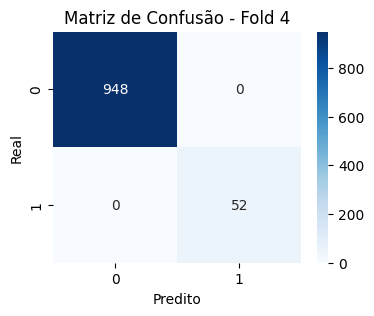

Counter({0: 8527, 1: 8527})
Fold 05 | Acc: 1.0000 | Prec: 1.0000 | Recall: 1.0000 | F1: 1.0000| Tempo Treino: 0.0294| Tempo Teste: 0.0528
Matriz de Confusão:
[[947   0]
 [  0  53]]


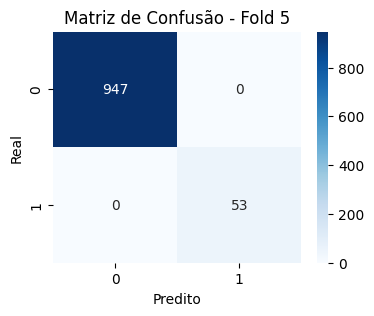

Counter({0: 8527, 1: 8527})
Fold 06 | Acc: 1.0000 | Prec: 1.0000 | Recall: 1.0000 | F1: 1.0000| Tempo Treino: 0.0459| Tempo Teste: 0.0212
Matriz de Confusão:
[[947   0]
 [  0  53]]


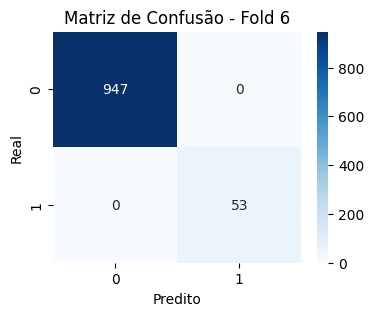

Counter({0: 8527, 1: 8527})
Fold 07 | Acc: 1.0000 | Prec: 1.0000 | Recall: 1.0000 | F1: 1.0000| Tempo Treino: 0.0293| Tempo Teste: 0.0185
Matriz de Confusão:
[[947   0]
 [  0  53]]


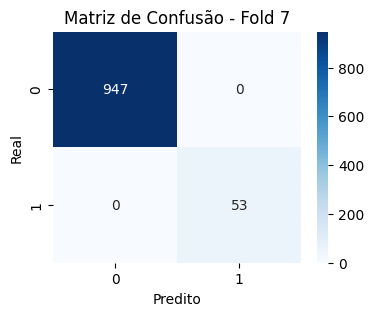

Counter({0: 8527, 1: 8527})
Fold 08 | Acc: 1.0000 | Prec: 1.0000 | Recall: 1.0000 | F1: 1.0000| Tempo Treino: 0.0261| Tempo Teste: 0.0490
Matriz de Confusão:
[[947   0]
 [  0  53]]


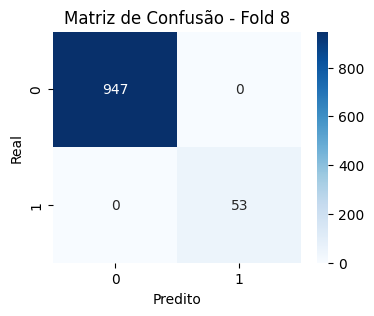

Counter({0: 8527, 1: 8527})
Fold 09 | Acc: 1.0000 | Prec: 1.0000 | Recall: 1.0000 | F1: 1.0000| Tempo Treino: 0.1156| Tempo Teste: 0.0741
Matriz de Confusão:
[[947   0]
 [  0  53]]


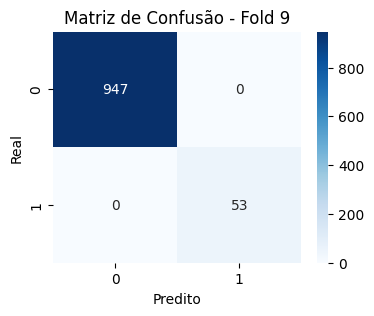

Counter({0: 8527, 1: 8527})
Fold 10 | Acc: 1.0000 | Prec: 1.0000 | Recall: 1.0000 | F1: 1.0000| Tempo Treino: 0.0622| Tempo Teste: 0.0452
Matriz de Confusão:
[[947   0]
 [  0  53]]


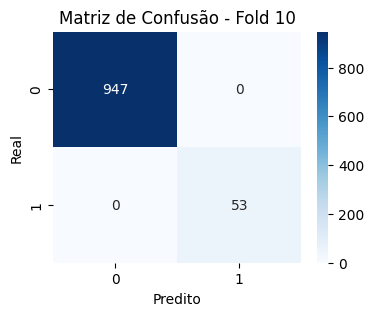

In [47]:
kf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

tempo_treino = []
tempo_teste = []

acc_list = []
prec_list = []
recall_list = []
f1_list = []

for fold, (train_index, test_index) in enumerate(kf.split(X, y), 1):

    X_train = X.iloc[train_index]
    X_test  = X.iloc[test_index]
    y_train = y.iloc[train_index]
    y_test  = y.iloc[test_index]


    scaler = MinMaxScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled  = scaler.transform(X_test)


    smt = SMOTE(random_state=20, sampling_strategy='auto')
    X_train_smt, y_train_smt = smt.fit_resample(X_train_scaled, y_train)
    print(Counter(y_train_smt))

    clf = KNeighborsClassifier()


    start_train = time.perf_counter()
    clf.fit(X_train_smt, y_train_smt)
    tempo_treino.append(time.perf_counter() - start_train)


    start_test = time.perf_counter()
    y_pred = clf.predict(X_test_scaled)
    tempo_teste.append(time.perf_counter() - start_test)

    acc_list.append(accuracy_score(y_test, y_pred))
    prec_list.append(precision_score(y_test, y_pred))
    recall_list.append(recall_score(y_test, y_pred))
    f1_list.append(f1_score(y_test, y_pred))

    print(f"Fold {fold:02d} | "
          f"Acc: {acc_list[-1]:.4f} | "
          f"Prec: {prec_list[-1]:.4f} | "
          f"Recall: {recall_list[-1]:.4f} | "
          f"F1: {f1_list[-1]:.4f}| "
          f"Tempo Treino: {tempo_treino[-1]:.4f}| "
          f"Tempo Teste: {tempo_teste[-1]:.4f}")

    cm = confusion_matrix(y_test, y_pred)
    print("Matriz de Confusão:")
    print(cm)

    # Visualização
    plt.figure(figsize=(4, 3))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.xlabel("Predito")
    plt.ylabel("Real")
    plt.title(f"Matriz de Confusão - Fold {fold}")
    plt.show()


In [48]:
kf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

tempo_treino = []
tempo_teste = []

acc_list = []
prec_list = []
recall_list = []
f1_list = []

for fold, (train_index, test_index) in enumerate(kf.split(X, y), 1):

    X_train = X.iloc[train_index]
    X_test  = X.iloc[test_index]
    y_train = y.iloc[train_index]
    y_test  = y.iloc[test_index]


    smt = SMOTE(random_state=20, sampling_strategy='auto')
    X_train_smt, y_train_smt = smt.fit_resample(X_train, y_train)


    clf = RandomForestClassifier()


    start_train = time.perf_counter()
    clf.fit(X_train_smt, y_train_smt)
    tempo_treino.append(time.perf_counter() - start_train)


    start_test = time.perf_counter()
    y_pred = clf.predict(X_test)
    y_pred_proba = clf.predict_proba(X_test)
    #print(y_pred_proba)
    #Uma predicao interessante para classificacao, enquanto predict() diz apenas 0 ou 1, predict_proba() diz quão confiante o modelo está.
    tempo_teste.append(time.perf_counter() - start_test)

    acc_list.append(accuracy_score(y_test, y_pred))
    prec_list.append(precision_score(y_test, y_pred, zero_division=0))
    recall_list.append(recall_score(y_test, y_pred))
    f1_list.append(f1_score(y_test, y_pred))

    print(f"Fold {fold:02d} | "
          f"Acc: {acc_list[-1]:.4f} | "
          f"Prec: {prec_list[-1]:.4f} | "
          f"Recall: {recall_list[-1]:.4f} | "
          f"F1: {f1_list[-1]:.4f}")


Fold 01 | Acc: 1.0000 | Prec: 1.0000 | Recall: 1.0000 | F1: 1.0000
Fold 02 | Acc: 1.0000 | Prec: 1.0000 | Recall: 1.0000 | F1: 1.0000
Fold 03 | Acc: 1.0000 | Prec: 1.0000 | Recall: 1.0000 | F1: 1.0000
Fold 04 | Acc: 1.0000 | Prec: 1.0000 | Recall: 1.0000 | F1: 1.0000
Fold 05 | Acc: 1.0000 | Prec: 1.0000 | Recall: 1.0000 | F1: 1.0000
Fold 06 | Acc: 1.0000 | Prec: 1.0000 | Recall: 1.0000 | F1: 1.0000
Fold 07 | Acc: 1.0000 | Prec: 1.0000 | Recall: 1.0000 | F1: 1.0000
Fold 08 | Acc: 1.0000 | Prec: 1.0000 | Recall: 1.0000 | F1: 1.0000
Fold 09 | Acc: 1.0000 | Prec: 1.0000 | Recall: 1.0000 | F1: 1.0000
Fold 10 | Acc: 1.0000 | Prec: 1.0000 | Recall: 1.0000 | F1: 1.0000


In [49]:
print("Top atributos mais importantes:")
atributos_importances = clf.feature_importances_
atributos_df = pd.DataFrame({
    'Atributos': X.columns,
    'Importancia': atributos_importances
}).sort_values('Importancia', ascending=False)
print(atributos_df.head(10))

Top atributos mais importantes:
                    Atributos  Importancia
1            taxa_crescimento     0.521291
0           crescimento_anual     0.220265
2              media_movel_3m     0.194721
3        desvio_padrao_mensal     0.063392
4  mes_atual_vs_media_passada     0.000332


**Interpretação dos resultados**

A análise de importância das variáveis indica que atributos derivados, especialmente a taxa de crescimento anual do consumo, concentram a maior parte do poder preditivo do modelo.


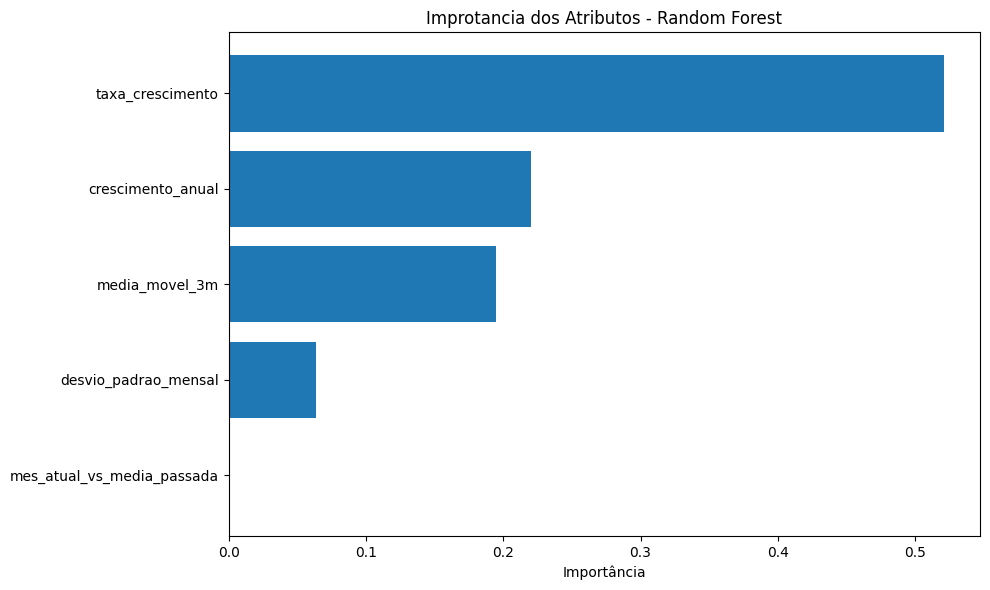

In [50]:
# Visualizar as importâncias
plt.figure(figsize=(10, 6))
bars = plt.barh(range(len(atributos_df)), atributos_df['Importancia'])
plt.yticks(range(len(atributos_df)), atributos_df['Atributos'])
plt.xlabel('Importância')
plt.title('Improtancia dos Atributos - Random Forest')
plt.gca().invert_yaxis()

plt.tight_layout()
plt.savefig('atributos_importancia_fraude_energia.png')
plt.show()


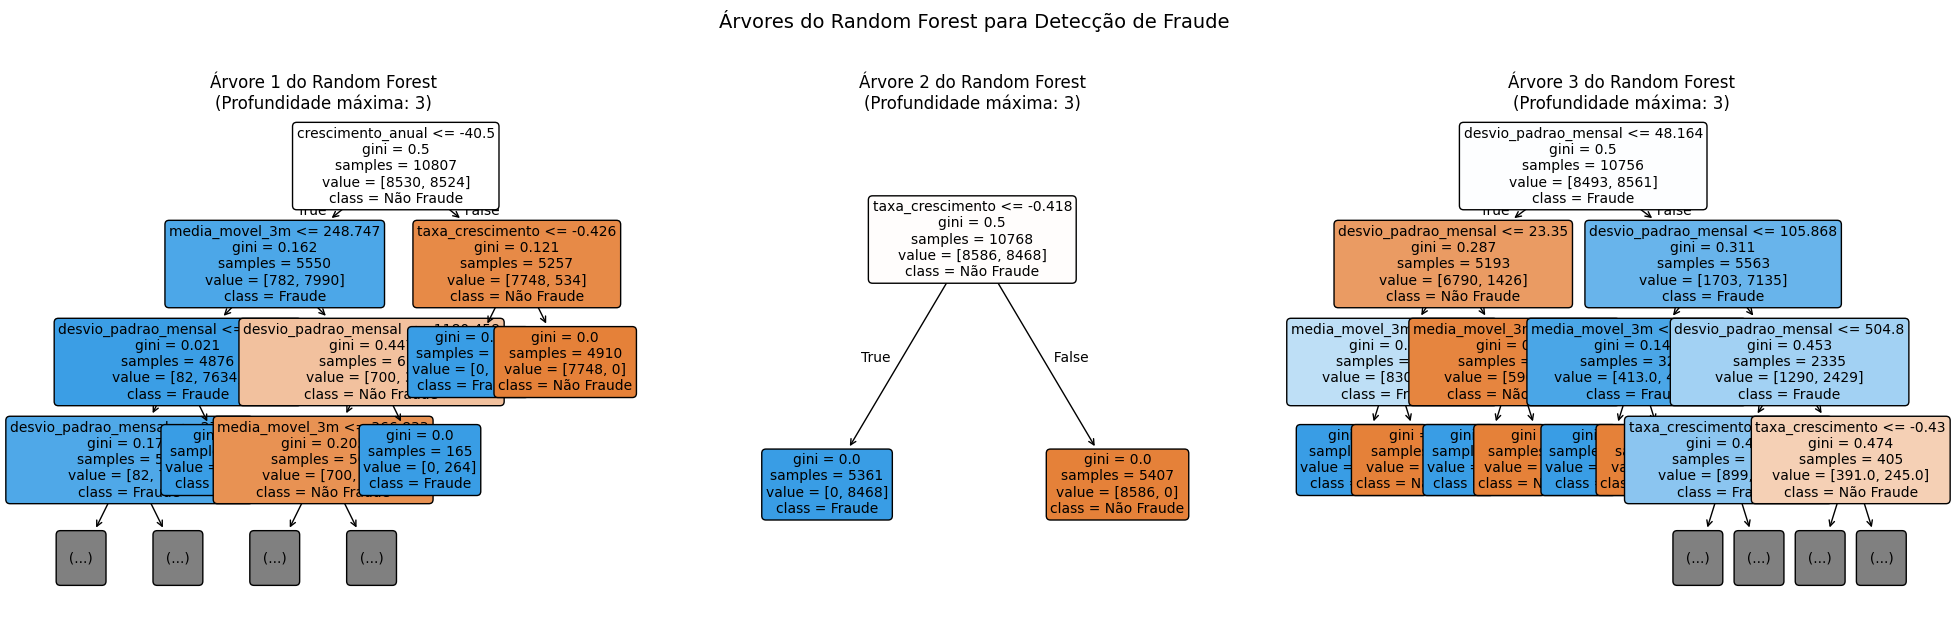

In [51]:
# Selecionar algumas árvores para visualizar
n_trees_to_plot = 3
n_cols = min(3, n_trees_to_plot)
n_rows = (n_trees_to_plot + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, n_rows * 6))
axes = axes.flatten() if n_trees_to_plot > 1 else [axes]

for i in range(n_trees_to_plot):
    ax = axes[i]

    plot_tree(clf.estimators_[i],
              feature_names=X.columns,
              class_names=['Não Fraude', 'Fraude'],
              filled=True,
              rounded=True,
              max_depth=3,  # Limitar profundidade para visualização
              ax=ax,
              fontsize=10)

    ax.set_title(f'Árvore {i+1} do Random Forest\n(Profundidade máxima: 3)', fontsize=12)


for j in range(i+1, len(axes)):
    axes[j].axis('off')

plt.suptitle('Árvores do Random Forest para Detecção de Fraude', fontsize=14, y=1.02)
plt.tight_layout()
plt.savefig('random_forest_trees.png')
plt.show()

#### **Qual seria a inovação técnica ou metodológica que este modelo poderia trazer em um projeto P&D ANEEL de grande porte?**

A principal inovação do modelo proposto reside na integração entre detecção de fraudes, exploração da predição probabilística de risco e interpretabilidade, aplicada a um contexto operacional real de energia elétrica. O modelo combina predição binária com estimativas probabilísticas de risco (predict_proba), permitindo quantificar o grau de incerteza associado a cada decisão. Os atributos temporais desenvolvidos capturam padrões de evasão e consumo anômalo que seriam difíceis de detectar com análises mensais isoladas, o que pode contribuir para a redução de inspeções desnecessárias.


Outro aspecto é a interpretabilidade do modelo. Ao empregar algoritmos baseados em árvores de decisão, como o Random Forest, o modelo possibilita a análise do conhecimento aprendido durante o treinamento, por meio da avaliação da importância das variáveis e da lógica subjacente às decisões. Essa transparência é particularmente relevante em projetos P&D ANEEL, pois facilita a validação técnica, rastreabilidade das decisões, além de aumentar a confiança das equipes técnicas na adoção do modelo.


Do ponto de vista metodológico, a construção do modelo incorpora práticas de aprendizado de máquina, incluindo validação cruzada estratificada, técnicas de balanceamento de classes via SMOTE e avaliação baseada em múltiplas métricas de desempenho. Esse conjunto de estratégias reforça a robustez da abordagem e sua adequação a cenários reais, caracterizados por forte desbalanceamento entre classes.


Limitações e desafios


Apesar dos resultados promissores, o modelo apresenta desafios que devem ser considerados. A qualidade e a relevância das variáveis de entrada são fatores críticos, sendo necessária uma análise criteriosa para evitar redundâncias e possíveis vazamentos de informação. Além disso, o desempenho do modelo pode ser aprimorado com a incorporação de variáveis  adicionais, como informações operacionais, que permitam capturar de forma mais abrangente o contexto do consumo energético.

##### **Referências Bases**

RUSSELL, Stuart; NORVIG, Peter. Inteligência Artificial: uma abordagem moderna. Campus,, 2004.

FACELI, Katti et al. Inteligência artificial: uma abordagem de aprendizado de máquina. 2021.